<a href="https://colab.research.google.com/github/Egoago/Onlab/blob/main/%C3%96nlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D regression

##Imports

In [193]:
import numpy as np
from numpy import arange
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors
from math import ceil
import tensorflow as tf
from tensorflow import norm
from tensorflow.math import reduce_mean, abs
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.initializers import RandomNormal, Zeros, Constant
from pylab import cm,imshow,contour,clabel,colorbar

##Preparing the data

###Defining the control points

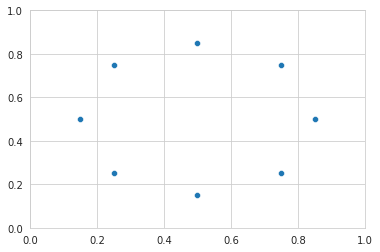

In [194]:
np.random.seed(1)
points = np.array([
                   [0.25,0.25],
                   [0.5,0.15],
                   [0.75,0.25],
                   [0.85,0.5],
                   [0.75,0.75],
                   [0.5,0.85],
                   [0.25,0.75],
                   [0.15,0.5]
                   ])
sns.scatterplot(x=points[:,0], y=points[:,1]).set(xlim=(0,1),ylim=(0,1));

###Defining training data generator

In [195]:
class DataGenerator(Sequence):
  seed = 0
  def __init__(self, dataCount, batch_size, controlPoints):
    self.controlPoints = controlPoints
    self.dataCount = dataCount
    self.batch_size = batch_size
    self.seed = DataGenerator.seed
    DataGenerator.seed += 1
    self.randGen = np.random.default_rng(seed=self.seed)

  def __len__(self):
    return ceil(self.dataCount / self.batch_size)

  def dist(self, p):
    return np.linalg.norm(self.controlPoints-p, axis = 1).min()

  def __getitem__(self, idx):
    P = []
    d = []
    for i in range(self.batch_size):
      p = self.randGen.random(2)
      P.append(p)
      d.append(self.dist(p))
    return np.array(P), np.array(d)

  #def on_epoch_end(self):
    #self.randGen = np.random.default_rng(seed=self.seed)
  
  def getAll(self):
    self.on_epoch_end()
    P = []
    d = []
    for i in range(self.batch_size * self.__len__()):
      p = self.randGen.random(2)
      P.append(p)
      d.append(self.dist(p))
    self.on_epoch_end()
    return np.array(P), np.array(d)

###Creating generators

In [196]:
pointNum = 30000
testSplit  = 0.1
trainPointNum = int(pointNum*(1-testSplit))
testPointNum = int(pointNum*testSplit)

trainGen = DataGenerator(trainPointNum, 8, points)
testGen = DataGenerator(testPointNum, testPointNum, points)

##Creating model

In [197]:
class CustomModel(Model):
  def __init__(self, *args, **kwargs):
    Model.__init__(self, *args, **kwargs)
    self.stepCounter = 0
    self.eikonalLambda = 0.2

  def train_step(self, data):
    x, y = data
    trainableVariables = self.trainable_variables
    with tf.GradientTape() as backpropTape:
      backpropTape.watch(trainableVariables)

      surfacePred = self(points, training=True)
      with tf.GradientTape() as eikonalTape:
        eikonalTape.watch(x)
        volumePred = self(x, training=True)
      volumeGrad = eikonalTape.gradient(volumePred, x)
      
      surfaceLoss = reduce_mean(abs(surfacePred))
      eikonalLoss = reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2)
      
      loss = surfaceLoss + self.eikonalLambda * eikonalLoss

    self.optimizer.minimize(loss, trainableVariables, tape=backpropTape)
    return {"loss": loss}
  
  def test_step(self, data):
    x, y = data
    surfacePred = self(points, training=False)
    with tf.GradientTape() as eikonalTape:
      eikonalTape.watch(x)
      volumePred = self(x, training=True)
    volumeGrad = eikonalTape.gradient(volumePred, x)
    
    surfaceLoss = reduce_mean(abs(surfacePred))
    eikonalLoss = reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2)
    
    loss = surfaceLoss + self.eikonalLambda * eikonalLoss
    return {"loss": loss}

Model: "custom_model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_53 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_54 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 129       
Total params: 17,025
Trainable params: 17,025
Non-trainable params: 0
_________________________________________________________________


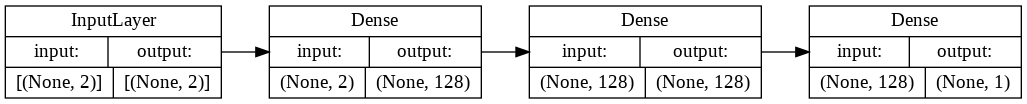

In [198]:
inputLayer = Input(shape=(2,))
#Dropout1 = Dropout(0.2)(hiddenLayer1)
hiddenLayer1 = Dense(128,
                     activation='softplus',
                     kernel_initializer= RandomNormal(stddev=np.sqrt(2)/np.sqrt(128)),
                     bias_initializer=Zeros())(inputLayer)
hiddenLayer2 = Dense(128,
                     activation='softplus',
                     kernel_initializer= RandomNormal(mean=np.pi/np.sqrt(128), stddev=0.00001),
                     bias_initializer=Constant(-1))(hiddenLayer1)
outputLayer = Dense(1, activation='linear')(hiddenLayer2)

model = CustomModel(inputs = inputLayer, outputs = outputLayer)
model.compile(optimizer = Adam(lr = 0.0015))
model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR')

##Train

In [201]:
def plot( model, plotSize='big'):
    sizeDict = {
        'big': ((13,10), 200, 0.05),
        'medium': ((8,5), 100, 0.1),
        'small': ((4,3), 40, 0.2),
    }
    figSize, resolution, lineDensity = sizeDict[plotSize]
    plt.figure(figsize=figSize)
    grid = np.empty((resolution*resolution,2))
    for y in range(resolution):
      for x in range(resolution):
        grid[y*resolution+x] = [x/resolution, y/resolution]
    prediction = np.array(model.predict(grid).reshape((resolution,resolution)))
    grid = []

    max = np.max(prediction)
    min = np.min(prediction)
    if (abs(min) > max):
      max = abs(min)
    im = imshow(prediction,
                cmap = sns.diverging_palette(220, 20, as_cmap=True),
                origin='lower',
                norm = colors.Normalize(vmin=-max, vmax=max))
    plt.axis('off')
    colorbar(im)
    cset = contour(prediction,arange(-0.6,0.6,lineDensity),linewidths=2,cmap='gray_r')
    clabel(cset,inline=True,fmt='%1.2f',fontsize=10)
    plot = sns.scatterplot(x=points[:,0]*resolution,
                    y=points[:,1]*resolution,
                    color = 'grey',
                    s = 80,
                    linewidth = 0)
    prediction = []
    plt.show()

class PlotCallback(Callback):
  def __init__(self, model, step=2):
    self.model = model
    self.step = step
    self.plots = []

  def on_train_begin(self, logs=None):
    plot(self.model, plotSize='medium')

  def on_epoch_end(self, epoch, logs=None):
    if (epoch%self.step == 0):
      plot(self.model, plotSize='small')

  def on_train_end(self, logs=None):
    plot(self.model, plotSize='big')

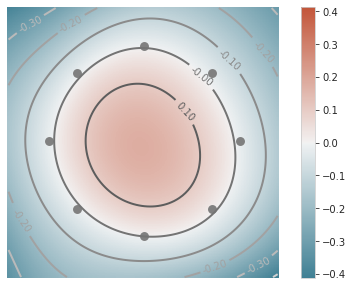

Epoch 1/2
3375/3375 [==============================] - 7s 2ms/step - loss: 0.0487


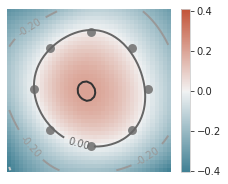

Epoch 2/2
3375/3375 [==============================] - 7s 2ms/step - loss: 0.0430


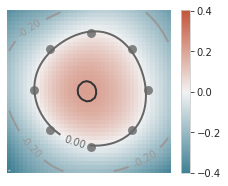

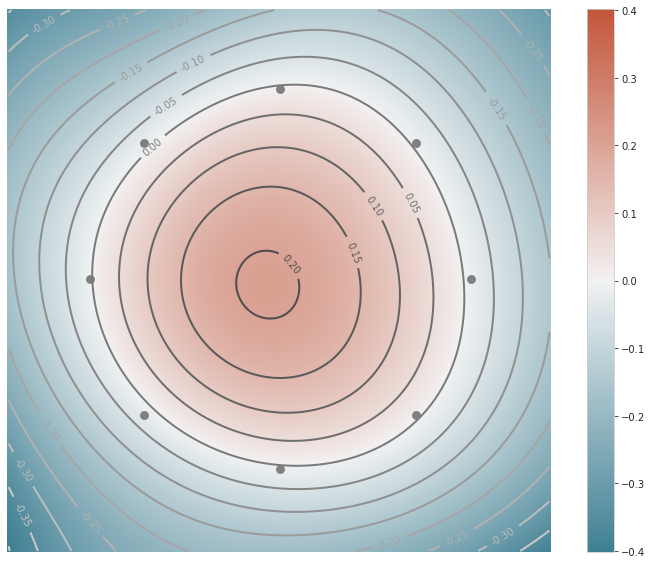

In [202]:
epochs = 2
history = model.fit(trainGen,
                    verbose = 1,
                    callbacks = [PlotCallback(model,1)],
                    epochs = epochs)